# Polarisation and the perimeter elasticity model

The relevant model is described in [Mapeng Bi et al.](https://arxiv.org/abs/1409.0593v4) (
[nature physics version](https://www.nature.com/articles/nphys3471))

The master equation is the following:

$$\epsilon = \sum_\alpha \left[ (a_\alpha - 1)^2 + \frac{(p_\alpha - p_0)^2}{r}\right]$$

With a unit prefered area and $p_\alpha$ the cell perimeter. This model has the advantage of providing 

Here, we modify this equation by modulating the contribution of each junction of a cell to account for polarity, such that:

$$ p_\alpha =  \frac{\sum_{ij \in \alpha} w_{ij}\ell_{ij}}{\sum_{ij \in \alpha} w_{ij}}n_{ij} $$

### Imports

In [86]:
import numpy as np
import pandas as pd

from tyssue import config, Sheet, PlanarGeometry
from tyssue.solvers import QSSolver

from tyssue.solvers.viscous import EulerSolver
from tyssue.draw import sheet_view

from tyssue.dynamics.factory import model_factory
from tyssue.dynamics import effectors, units
from tyssue.utils import to_nd
from tyssue.utils.testing import effector_tester, model_tester
from tyssue.behaviors import EventManager
from tyssue.behaviors.sheet import basic_events

from tyssue.draw import highlight_faces, create_gif

### Create a 2D patch of cells

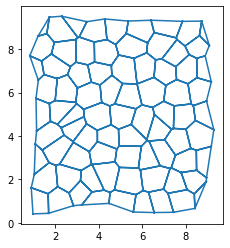

In [87]:
base_geom = PlanarGeometry

sheet = Sheet.planar_sheet_2d('jam', 15, 15, 1, 1, noise=0.2)
base_geom.update_all(sheet)

sheet.remove(sheet.cut_out([[0, 10], [0, 10]]), trim_borders=True)
sheet.sanitize()
base_geom.scale(sheet, sheet.face_df.area.mean()**-0.5, ['x', 'y'])
base_geom.update_all(sheet)
sheet.reset_index()
sheet.reset_topo()
fig, ax = sheet_view(sheet, mode="quick")

### Define the relevant mechanical components 

In [107]:
sheet.edge_df["weight"]

edge
0      1.450950
1      1.001473
2      1.001473
3      1.386253
4      1.386253
         ...   
420    1.009949
421    1.105588
422    1.007602
423    1.017377
424    1.002400
Name: weight, Length: 425, dtype: float64

In [111]:
buff = sheet.edge_df.groupby('face').apply(
    lambda df: (df["num_sides"] * df["weight"]
                / df["weight"].sum()))

In [118]:
sheet.edge_df['test'] = buff.sort_index(level='edge').to_numpy()

In [120]:
class WPGeometry(base_geom):
    
    @classmethod
    def update_all(cls, sheet):
        base_geom.update_all(sheet)
        cls.update_perimeters(sheet)
    
    @staticmethod
    def update_perimeters(sheet):
        weighted_lengths = sheet.edge_df.eval("weight * length")
        sheet.face_df['perimeter'] = sheet.sum_face(weighted_lengths)
        
    
    @staticmethod
    def normalize_weights(sheet):
        sheet.edge_df["num_sides"] = sheet.upcast_face('num_sides')
        sheet.edge_df["weight"] = sheet.edge_df.groupby('face').apply(
            lambda df: (df["num_sides"] * df["weight"]
                        / df["weight"].sum())
        ).sort_index(level='edge').to_numpy()
        
geom = WPGeometry
# From Mapeng Bi et al.
class PermiterElasticity(effectors.AbstractEffector):
    
    dimensions = units.line_elasticity
    magnitude = 'perimeter_elasticity'
    label = 'Perimeter Elasticity'
    element = 'face'
    specs = {
        'face': {
            'is_alive': 1,
            'perimeter': 1.0,
            'perimeter_elasticity': 1.0,
            'prefered_perimeter': 1.0
            }
        }

    spatial_ref = 'prefered_perimeter', units.length

    @staticmethod
    def energy(eptm):
        return eptm.face_df.eval('0.5 * is_alive'
                                 '* perimeter_elasticity'
                                 '* (perimeter - prefered_perimeter)** 2')

    @staticmethod
    def gradient(eptm):

        gamma_ = eptm.face_df.eval(
            'perimeter_elasticity * is_alive'
            '*  (perimeter - prefered_perimeter)')
        gamma = eptm.edge_df['weight'] * eptm.upcast_face(gamma_)

        grad_srce = - eptm.edge_df[eptm.ucoords] * to_nd(gamma,
                                                         len(eptm.coords))
        grad_srce.columns = ['g'+u for u in eptm.coords]
        grad_trgt = - grad_srce
        return grad_srce, grad_trgt


class WeightedPermiterElasticity(effectors.AbstractEffector):
    
    dimensions = units.line_elasticity
    magnitude = 'perimeter_elasticity'
    label = 'Perimeter Elasticity'
    element = 'face'
    specs = {
        'face': {
            'is_alive': 1,
            'perimeter': 1.0,
            'perimeter_elasticity': 1.0,
            'prefered_perimeter': 1.0
            }
        }

    spatial_ref = 'prefered_perimeter', units.length

    @staticmethod
    def energy(eptm):
        return eptm.face_df.eval('0.5 * is_alive'
                                 '* perimeter_elasticity'
                                 '* (perimeter - prefered_perimeter)** 2')

    @staticmethod
    def gradient(eptm):

        gamma_ = eptm.face_df.eval(
            'perimeter_elasticity * is_alive'
            '*  (perimeter - prefered_perimeter)')
        gamma = eptm.edge_df['weight'] * eptm.upcast_face(gamma_)

        grad_srce = - eptm.edge_df[eptm.ucoords] * to_nd(gamma,
                                                         len(eptm.coords))
        grad_srce.columns = ['g'+u for u in eptm.coords]
        grad_trgt = - grad_srce
        return grad_srce, grad_trgt

model_specs = {
    'face': {
        'area_elasticity': 1.,
        'prefered_area': 1.,
        'perimeter_elasticity': 0.1, # 1/2r in the master equation
        'prefered_perimeter': 3.4,
        'traction_x': 0.0,
        'traction_y': 0.0,
        },
    'edge': {'ux': 0, 'uy': 0, "weight": 1.0},
    'settings': {'temperature': 1e-2}
}
    
sheet.update_specs(model_specs, reset=True)
geom.normalize_weights(sheet)


Reseting column area_elasticity of the face dataset with new specs
Reseting column prefered_area of the face dataset with new specs
Reseting column perimeter_elasticity of the face dataset with new specs
Reseting column prefered_perimeter of the face dataset with new specs
Reseting column traction_x of the face dataset with new specs
Reseting column traction_y of the face dataset with new specs
Reseting column ux of the edge dataset with new specs
Reseting column uy of the edge dataset with new specs
Reseting column weight of the edge dataset with new specs


### Quasistatic gradient descent

With only the conservative potential terms

In [121]:

model = model_factory(
    [WeightedPermiterElasticity,
     effectors.FaceAreaElasticity])

res = QSSolver().find_energy_min(sheet, geom, model)

print(res.message)

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Backup so we can play with parameters

In [90]:
bck = sheet.copy()

## Pulling on a face

Chosen with trial and error

#### Simple visualisation

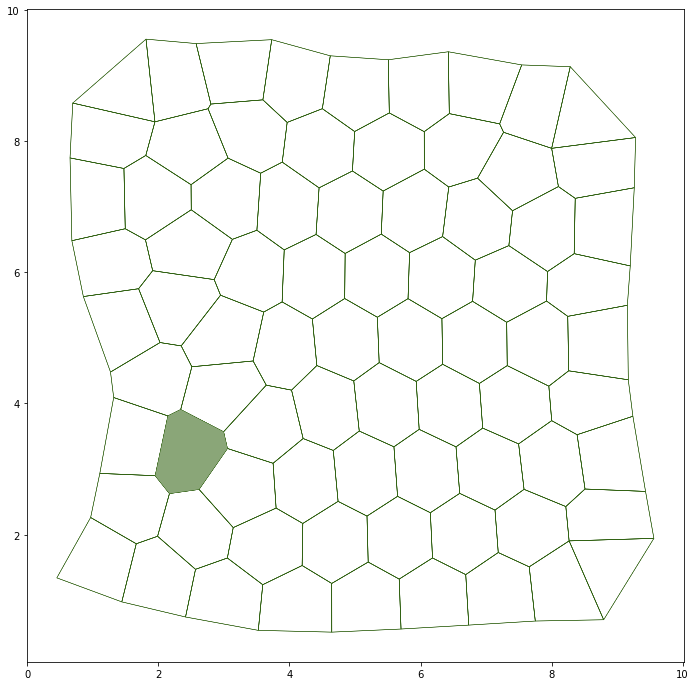

In [122]:
highlight_faces(sheet.face_df, [pulled,], reset_visible=True)
fig, ax = sheet_view(
    sheet, 
    mode="2D", 
    face={"visible": True},
    edge={"head_width": 0.0},
    vert={"visible": False})
fig.set_size_inches(12, 12)

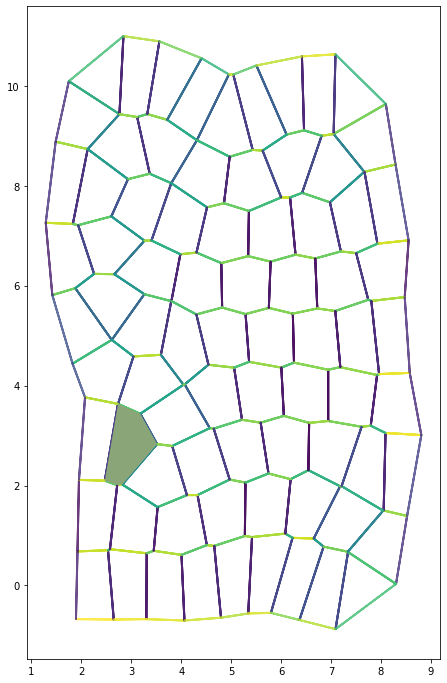

In [138]:
thetas = np.arctan(sheet.edge_df.dx/sheet.edge_df.dy)
sheet.edge_df['weight'] = 1 + np.abs(thetas) / np.pi
geom.normalize_weights(sheet)
fig, ax = sheet_view(
    sheet, 
    mode="2D", 
    face={"visible": True},
    edge={"head_width": 0.0, "width": 2.0, "color": sheet.edge_df['weight']}, 
    vert={"visible": False})
fig.set_size_inches(12, 12)

In [139]:
res = QSSolver().find_energy_min(sheet, geom, model)

print(res.message)

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


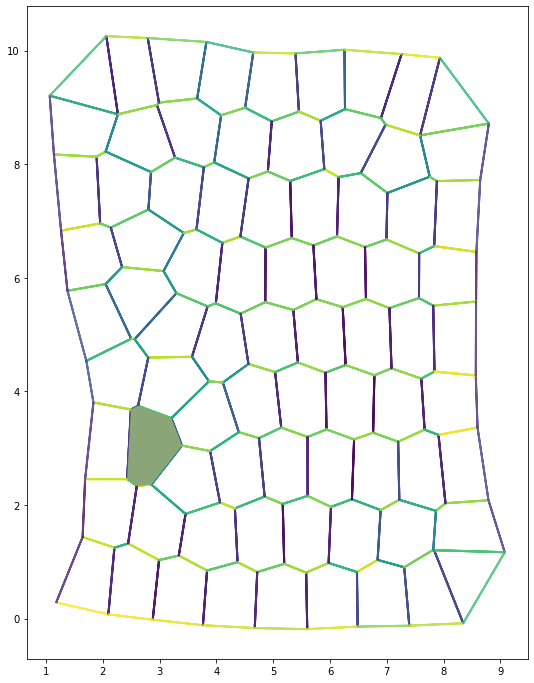

In [140]:
fig, ax = sheet_view(
    sheet, 
    mode="2D", 
    face={"visible": True},
    edge={
        "head_width": 0.0,
        "width": 2.0,
        "color": sheet.edge_df['weight']}, 
    vert={"visible": False})
fig.set_size_inches(12, 12)

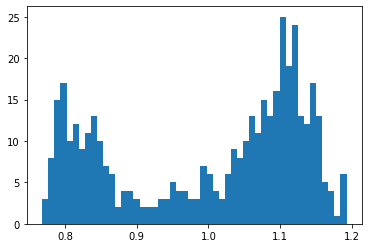

In [141]:
fig, ax = plt.subplots()

_ = ax.hist(sheet.edge_df['weight'], bins=50)

In [99]:
sheet.edge_df.groupby("face")["weight"].sum()

face
0     7.354338
1     3.703312
2     7.320777
3     5.019816
4     6.090159
        ...   
72    8.685117
73    7.329551
74    7.312305
75    8.688438
76    6.173782
Name: weight, Length: 77, dtype: float64